In [1]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC

In [2]:
# アジアン・バリアオプションのモンテカルロシミュレーション（インデックス渡し版）
function asian_barrier_option_tci(j, T, K, B, S0s, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)
    discounted_payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]
    for i in 1:N_PATHS
        s_curr = S0
        running_avg = 0.0
        for n in 1:N_STEPS
            s_curr += tmp1 * s_curr + sigma * s_curr * tmp3 * d_normals[i + (n-1)*N_PATHS]
            running_avg += (s_curr - running_avg) / n
            if running_avg <= B
                break
            end
        end
        discounted_payoffs[i] = tmp2 * max(running_avg - K, 0)
    end
    mean_payoff = mean(discounted_payoffs)
    std_payoff = std(discounted_payoffs)
    error = std_payoff / sqrt(N_PATHS)
    return mean_payoff
end

# アジアン・バリアオプションのモンテカルロシミュレーション（インデックス渡し版）
function asian_barrier_option_error(j, T, K, B, S0s, sigmas, mu, r, d_normals, N_STEPS, N_PATHS)
    tmp1 = mu * T / N_STEPS
    tmp2 = exp(-r * T)
    tmp3 = sqrt(T / N_STEPS)
    discounted_payoffs = zeros(Float64, N_PATHS)
    S0 = S0s[j[1]]
    sigma = sigmas[j[2]]
    for i in 1:N_PATHS
        s_curr = S0
        running_avg = 0.0
        for n in 1:N_STEPS
            s_curr += tmp1 * s_curr + sigma * s_curr * tmp3 * d_normals[i + (n-1)*N_PATHS]
            running_avg += (s_curr - running_avg) / n
            if running_avg <= B
                break
            end
        end
        discounted_payoffs[i] = tmp2 * max(running_avg - K, 0)
    end
    mean_payoff = mean(discounted_payoffs)
    std_payoff = std(discounted_payoffs)
    error = std_payoff / sqrt(N_PATHS)
    return mean_payoff, error
end

# TCIワンショット補間関数
function tci_oneshot(func, d, localdims, firstpivot, tol)
    BLAS.set_num_threads(4)
    for _ in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot)
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end
    qtt, ranks, errors = TCI.crossinterpolate2(Float64, func, localdims, [firstpivot],
                                                  tolerance=tol, maxiter=6, verbosity=1,
                                                  loginterval=1, pivotsearch=:rook)
    return qtt, errors
end

tci_oneshot (generic function with 1 method)

In [3]:
##########################################################
# パラメータの設定とグリッド生成
##########################################################
d = 2
N_STEPS = 365
N_PATHS = 1000       # サンプル数（テスト用なので少なめ）
T = 1.0
K = 110.0
B = 100.0
mu = 0.1
r = 0.05

Random.seed!(1234)
d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 100
n = num_nodes
S0_values = TCIMC.calc_cheby_abscissas(90.0, 120.0, num_nodes)
implied_vol_values = TCIMC.calc_cheby_abscissas(0.15, 0.25, num_nodes)

# インデックスを渡す設計のため、例として j = [30, 30] を利用
j = [30, 30]
println("Option Price (MC, single point): ", asian_barrier_option_tci(j, T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS))
println("Option Price (MC, single point): ", asian_barrier_option_error(j, T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS))


Option Price (MC, single point): 0.0
Option Price (MC, single point): (0.0, 0.0)


In [4]:
num_samples = 100
errors = zeros(Float64, num_samples)
prices = zeros(Float64, num_samples)

for i in 1:num_samples
    # 1～num_nodesの範囲からランダムにインデックスを選ぶ
    j1 = rand(1:num_nodes)
    j2 = rand(1:num_nodes)
    j = [j1, j2]

    price, price_error  = asian_barrier_option_error(
        j, T, K, B,
        S0_values, implied_vol_values,
        mu, r,
        d_normals,
        N_STEPS, N_PATHS
    )

    errors[i] = price_error
    prices[i] = price
end

In [5]:
maxsamplevalue = maximum(prices)
println("Max sample value: ", maxsamplevalue)
println("Min sample value: ", minimum(prices))
println("Mean Price: ", mean(prices))
println("Standard Deviation of Prices: ", std(prices))
println("Errors/maxsamplevalue: ", errors)
println("Mean Error/maxsamplevalue: ", mean(errors)/maxsamplevalue)
println("Standard Deviation of Errors / maxsamplevalue: ", std(errors)/maxsamplevalue)
println("Max Error/maxsamplevalue: ", maximum(errors)/maxsamplevalue)
println("Min Error/maxsamplevalue: ", minimum(errors)/maxsamplevalue)

Max sample value: 17.125669470613524
Min sample value: 0.0
Mean Price: 6.561299761446784
Standard Deviation of Prices: 6.085273574438112
Errors/maxsamplevalue: [0.20954833156637961, 0.4569835172594182, 0.0, 0.3175889503947148, 0.47359343742479415, 0.0, 0.38747528518554886, 0.06802347926290785, 0.31602081791385933, 0.351406496628889, 0.335844572957937, 0.2946785155127383, 0.0, 0.2612240726198412, 0.0, 0.1801268304255029, 0.40461734769390023, 0.4698047439354658, 0.0, 0.42336887487183394, 0.0, 0.0, 0.10232212545073419, 0.0, 0.20416045014597894, 0.0, 0.375088593850469, 0.47901311786889356, 0.3269802033865144, 0.20338874403375118, 0.4609092013389541, 0.2910999719170347, 0.0, 0.0, 0.0, 0.37660667446794577, 0.29666074601974446, 0.2488400954200095, 0.4819775605410291, 0.0, 0.31730541951664415, 0.06888780752087377, 0.4584430895321974, 0.0, 0.5182864258118923, 0.3703929974267856, 0.0, 0.0, 0.5155752393494881, 0.0, 0.07115523138583758, 0.22256087033790398, 0.4058548213062624, 0.0, 0.2575533579636

In [6]:
j = [100, 100]
price, price_error  = asian_barrier_option_error(
        j, T, K, B,
        S0_values, implied_vol_values,
        mu, r,
        d_normals,
        N_STEPS, N_PATHS
    )

tol_mc = price_error / price

0.03038718241470662

In [7]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
abo(j) = asian_barrier_option_tci(j, T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
localdims_v = fill(num_nodes, d)
firstpivot_v = rand(1:num_nodes, d)
phi = TCI.CachedFunction{Float64}(abo, localdims_v)
tol = tol_mc

tci_time = @elapsed begin
    tt_tci, errors_asianbarrier = tci_oneshot(phi, d, localdims_v, firstpivot_v, tol)
end

##########################################################

iteration = 1, rank = 1, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0
iteration = 2, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0
iteration = 3, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0
iteration = 4, rank = 2, error= 0.0, maxsamplevalue= 17.169054884123298, nglobalpivot=0


9.826946375

In [10]:
JLD2.@save "tt_tci_asian_barrier_$tol.jld2" tt_tci

In [13]:
# Grid上での評価結果の比較（TCI vs. Monte Carlo）
##########################################################
# TCIによる評価結果の行列（TT評価はTCIMC._evaluateを利用）
price_matrix_tci = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_tci[i, j] = TCIMC._evaluate(tt_tci.sitetensors, [i, j])
end

# Monte Carloによる評価結果の行列
price_matrix_mc = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_mc[i, j] = asian_barrier_option_tci([i, j], T, K, B, S0_values, implied_vol_values, mu, r, d_normals, N_STEPS, N_PATHS)
end

tol_svd = 1e-3
US, Vt = TCI._factorize(price_matrix_mc, :SVD; tolerance = tol_svd, maxbonddim=1000)
U_core = reshape(US, 1, size(US)[1], size(US)[2])
Vt_core = reshape(Vt, size(Vt)[1], size(Vt)[2], 1)

tt_svd_ = [U_core, Vt_core]
@show size(U_core)
@show size(Vt_core)

tt_svd = TCI.TensorTrain(tt_svd_)
#tt_sin_svd.sitetensors

price_matrix_svd = zeros(n, n)
for i in 1:n, j in 1:n
    price_matrix_svd[i,j] = TCIMC._evaluate(tt_svd.sitetensors, [i, j])
end

size(U_core) = (1, 100, 3)
size(Vt_core) = (3, 100, 1)


In [14]:
JLD2.@save "tt_svd_asian_barrier_$tol_svd.jld2" tt_svd

In [28]:
M_dct = TCIMC.dct_matrix(n)
C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, 2))
C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_svd), fill(M_dct, 2))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

## original function

In [29]:
using Statistics, Random

#num_nodes = n
S0_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes))

# 全インデックスの組を作成して、ランダムに100点抽出

Random.seed!(1234)
all_idx_pairs = [(i, j) for i in 1:num_nodes, j in 1:num_nodes]
rand_idx_pairs = rand(vec(all_idx_pairs), 100)


# -----------------------------------
# TCI による価格評価
# -----------------------------------
price_dict_tci = Dict{Tuple{Int,Int}, Float64}()
for (i_idx, j_idx) in rand_idx_pairs
    s0_val = S0_values_equiv[i_idx]
    vol_val = implied_vol_values_equiv[j_idx]

    weights = [TCIMC.chebyshev_basis(90.0, 120.0, s0_val, n),
               TCIMC.chebyshev_basis(0.15, 0.25, vol_val, n)]
    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    price_dict_tci[(i_idx, j_idx)] = result_original
end


# -----------------------------------
# SVD による価格評価
# -----------------------------------
price_dict_svd = Dict{Tuple{Int,Int}, Float64}()
for (i_idx, j_idx) in rand_idx_pairs
    s0_val = S0_values_equiv[i_idx]
    vol_val = implied_vol_values_equiv[j_idx]

    weights = [TCIMC.chebyshev_basis(90.0, 120.0, s0_val, n),
               TCIMC.chebyshev_basis(0.15, 0.25, vol_val, n)]
    c = 1
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_svd, left_cache, right_cache, weights[c], c)

    price_dict_svd[(i_idx, j_idx)] = result_original
end


#=
# -----------------------------------
# Monte Carlo 10^8による価格評価
# -----------------------------------
N_PATHS_true = 1000
price_dict_mc_true = Dict{Tuple{Int,Int}, Float64}()
for (i_idx, j_idx) in rand_idx_pairs
    result_mc = asian_barrier_option_tci(
        [i_idx, j_idx], T, K, B, S0_values_equiv, implied_vol_values_equiv, mu, r, d_normals, N_STEPS, N_PATHS_true)
    price_dict_mc_true[(i_idx, j_idx)] = result_mc
end

=#

# -----------------------------------
# Monte Carlo 10^6による誤差評価
# -----------------------------------
price_dict_mc = Dict{Tuple{Int,Int}, Float64}()
price_dict_mc_err = Dict{Tuple{Int,Int}, Float64}()
for (i_idx, j_idx) in rand_idx_pairs
    result_mc, error_mc = asian_barrier_option_error(
        [i_idx, j_idx], T, K, B, S0_values_equiv, implied_vol_values_equiv, mu, r, d_normals, N_STEPS, N_PATHS)
    price_dict_mc[(i_idx, j_idx)] = result_mc
    price_dict_mc_err[(i_idx, j_idx)] = error_mc
end



JLD2.@save "price_dict_mc.jld2" price_dict_mc
JLD2.@save "price_dict_mc_err.jld2" price_dict_mc_err
JLD2.@save "price_dict_tci.jld2" price_dict_tci
JLD2.@save "price_dict_svd.jld2" price_dict_svd

#=
# -----------------------------------
# 誤差評価
# -----------------------------------
abs_errors = [abs(price_dict_tci[idx] - price_dict_mc_true[idx]) for idx in rand_idx_pairs]
max_error = maximum(abs_errors)
rmse = sqrt(mean(abs_errors .^ 2))

abs_errors_svd = [abs(price_dict_svd[idx] - price_dict_mc_true[idx]) for idx in rand_idx_pairs]
max_error_svd = maximum(abs_errors_svd)
rmse_svd = sqrt(mean(abs_errors_svd .^ 2))

# -----------------------------------
# 表示
# -----------------------------------
println("abs_errors: ", abs_errors)
println("最大絶対誤差: ", max_error)
println("RMSE: ", rmse)
println("最大絶対誤差 (SVD): ", max_error_svd)
println("RMSE (SVD): ", rmse_svd)
println("最大絶対誤差 (TCI): ", maximum(abs_errors_svd))
println("price_dict_mc_err=", mean(price_dict_mc_err[i] for i in rand_idx_pairs))
=#


## S0を固定した上で、sigma方向に計算ver

In [30]:
# -------------------------------
# どこかで定義済みの辞書 (TCI, SVD, MC) 
# 存在しない場合は空の Dict を用意
# -------------------------------
price_dict_tci = Dict{Tuple{Int,Int}, Float64}()
price_dict_svd = Dict{Tuple{Int,Int}, Float64}()
price_dict_mc  = Dict{Tuple{Int,Int}, Float64}()

# -------------------------------
# 行をひとつ選択
# -------------------------------
row_index = 90  # 例: 10行目（S0= S0_values_equiv[10]）
# row_index = rand(1:num_nodes)  # ランダムに選ぶならこちら

selected_S0 = S0_values_equiv[row_index]
println("選択した行 index: ", row_index, ",  S0 = ", selected_S0)

# -------------------------------
# 選択した行について、列を全て計算 or 再利用
# -------------------------------
tci_vals = Float64[]
svd_vals = Float64[]
mc_vals  = Float64[]
xvals    = Float64[]  # x 軸となる implied_vol_values_equiv[j]

for j in 1:num_nodes
    vol_val = implied_vol_values_equiv[j]
    push!(xvals, vol_val)  # x 軸に追加
    
    # ========== TCI ==========
    if haskey(price_dict_tci, (row_index, j))
        price_tci = price_dict_tci[(row_index, j)]
    else
        # まだ辞書に無いなら計算して登録
        weights = [TCIMC.chebyshev_basis(90.0, 120.0, selected_S0, n),
                   TCIMC.chebyshev_basis(0.15, 0.25, vol_val, n)]
        c = 1
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
        price_tci = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
        price_dict_tci[(row_index, j)] = price_tci
    end
    push!(tci_vals, price_tci)

    # ========== SVD ==========
    if haskey(price_dict_svd, (row_index, j))
        price_svd = price_dict_svd[(row_index, j)]
    else
        weights = [TCIMC.chebyshev_basis(90.0, 120.0, selected_S0, n),
                   TCIMC.chebyshev_basis(0.15, 0.25, vol_val, n)]
        c = 1
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
        price_svd = TCIMC.update_center(C_coeff_tensor_svd, left_cache, right_cache, weights[c], c)
        price_dict_svd[(row_index, j)] = price_svd
    end
    push!(svd_vals, price_svd)

    # ========== MC ==========
    if haskey(price_dict_mc, (row_index, j))
        price_mc = price_dict_mc[(row_index, j)]
    else
        # Monte Carlo で計算 (asian_barrier_option_tciはユーザー定義と想定)
        price_mc = asian_barrier_option_tci(
            [row_index, j], T, K, B, S0_values_equiv, implied_vol_values_equiv, mu, r, d_normals,
            N_STEPS, N_PATHS
        )
        price_dict_mc[(row_index, j)] = price_mc
    end
    push!(mc_vals, price_mc)
end




選択した行 index: 90,  S0 = 116.96969696969697


In [31]:
@JLD2.save "svd_vals_1d_vol_asian_barrier.jld2" svd_vals
@JLD2.save "tci_vals_1d_vol_asian_barrier.jld2" tci_vals
@JLD2.save "mc_vals_1d_vol_asian_barrier.jld2" mc_vals
@JLD2.save "xvals_1d_vol_asian_barrier.jld2" xvals


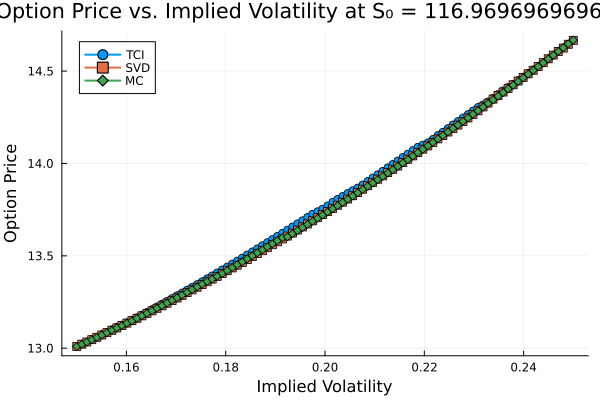

In [32]:
using Plots

# -------------------------------
# プロット設定
# -------------------------------
p = plot(
    xvals, tci_vals,
    label = "TCI",
    lw = 2,
    marker = :circle,
    xlabel = "Implied Volatility",
    ylabel = "Option Price",
    title = "Option Price vs. Implied Volatility at S₀ = $(selected_S0)",
    legend = :topleft,
    grid = true
)

plot!(xvals, svd_vals, label = "SVD", lw = 2, marker = :square)
plot!(xvals, mc_vals,  label = "MC",  lw = 2, marker = :diamond)

# -------------------------------
# プロットを表示
# -------------------------------
display(p)


## sigmaを固定した上で、S0方向に計算ver

In [33]:
# -------------------------------
# どこかで定義済みの辞書 (TCI, SVD, MC) 
# 存在しない場合は空の Dict を用意
# -------------------------------
price_dict_tci = Dict{Tuple{Int,Int}, Float64}()
price_dict_svd = Dict{Tuple{Int,Int}, Float64}()
price_dict_mc  = Dict{Tuple{Int,Int}, Float64}()

# -------------------------------
# 列をひとつ選択
# -------------------------------
col_index = 10  # 例: 10列目（vol = implied_vol_values_equiv[10]）
# col_index = rand(1:num_nodes)  # ランダムに選ぶならこちら

selected_vol = implied_vol_values_equiv[col_index]
println("選択した列 index: ", col_index, ",  vol = ", selected_vol)

# -------------------------------
# 選択した列について、行を全て計算 or 再利用
# -------------------------------
tci_vals = Float64[]
svd_vals = Float64[]
mc_vals  = Float64[]
xvals    = Float64[]  # x 軸となる S0_values_equiv[i]

for i in 1:num_nodes
    s0_val = S0_values_equiv[i]
    push!(xvals, s0_val)  # x 軸に追加 (今回は S0)

    # ========== TCI ==========
    if haskey(price_dict_tci, (i, col_index))
        price_tci = price_dict_tci[(i, col_index)]
    else
        # まだ辞書に無いなら計算して登録
        weights = [TCIMC.chebyshev_basis(90.0, 120.0, s0_val, n),
                   TCIMC.chebyshev_basis(0.15, 0.25, selected_vol, n)]
        c = 1
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
        price_tci = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)
        price_dict_tci[(i, col_index)] = price_tci
    end
    push!(tci_vals, price_tci)

    # ========== SVD ==========
    if haskey(price_dict_svd, (i, col_index))
        price_svd = price_dict_svd[(i, col_index)]
    else
        weights = [TCIMC.chebyshev_basis(90.0, 120.0, s0_val, n),
                   TCIMC.chebyshev_basis(0.15, 0.25, selected_vol, n)]
        c = 1
        left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_svd, weights, c)
        right_cache = TCIMC.compute_right_cache(C_coeff_tensor_svd, weights, c)
        price_svd = TCIMC.update_center(C_coeff_tensor_svd, left_cache, right_cache, weights[c], c)
        price_dict_svd[(i, col_index)] = price_svd
    end
    push!(svd_vals, price_svd)

    # ========== MC ==========
    if haskey(price_dict_mc, (i, col_index))
        price_mc = price_dict_mc[(i, col_index)]
    else
        # Monte Carlo で計算 (asian_barrier_option_tciはユーザー定義と想定)
        price_mc = asian_barrier_option_tci(
            [i, col_index], T, K, B, S0_values_equiv, implied_vol_values_equiv, mu, r, d_normals,
            N_STEPS, N_PATHS
        )
        price_dict_mc[(i, col_index)] = price_mc
    end
    push!(mc_vals, price_mc)
end


選択した列 index: 10,  vol = 0.1590909090909091


In [34]:
@JLD2.save "svd_vals_1d_S0_asian_barrier.jld2" svd_vals
@JLD2.save "tci_vals_1d_S0_asian_barrier.jld2" tci_vals
@JLD2.save "mc_vals_1d_S0_asian_barrier.jld2" mc_vals
@JLD2.save "xvals_1d_S0_asian_barrier.jld2" xvals

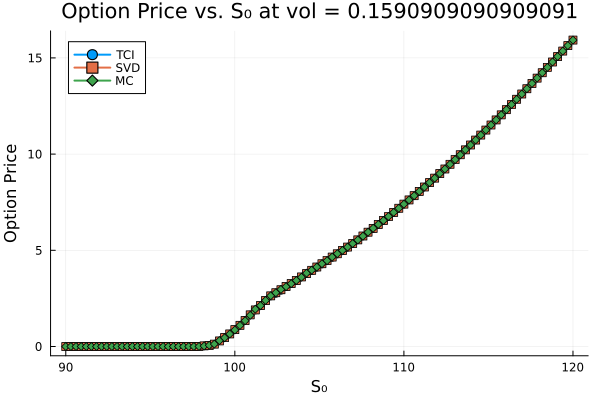

In [35]:
using Plots

p = plot(
    xvals, 
    tci_vals,
    label = "TCI",
    lw = 2,
    marker = :circle,
    xlabel = "S₀",
    ylabel = "Option Price",
    title = "Option Price vs. S₀ at vol = $(selected_vol)",
    legend = :topleft,
    grid = true
)

plot!(p, xvals, svd_vals, label = "SVD", lw = 2, marker = :square) # # #
plot!(p, xvals, mc_vals,  label = "MC",  lw = 2, marker = :diamond) # # #
display(p) #### 
